# Computing the Shortest Paths and Connected Components


## Shortest Paths

Now, let's do some exercise. First, let's consider a simple graph below.

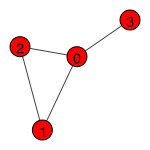

In [1]:
import igraph

g = igraph.Graph()
g.add_vertices(4)
g.add_edges([(0, 1), (1, 2), (0, 2), (0, 3)])
igraph.plot(g, bbox=(150, 150), vertex_label=list(range(4)))

In this straightforward example, there is at least one path connecting nodes 2 and 3. Let's generate the paths between them by using igraph.

In [2]:
g.get_all_simple_paths(2, to=3)

[[2, 0, 3], [2, 1, 0, 3]]

The lengths of the paths vary depending on which route we choose. We can get the shortest path by using the `get_shortest_paths` method.

In [3]:
g.get_shortest_paths(2, to=3)

[[2, 0, 3]]

Note that there can be multiple shortest paths between two nodes.

We can get the length of the shortest path by using `distances` method.

In [4]:
g.distances(2, 3)

[[2]]

## Connected Components

In the simple network above, we can see that for every pair of nodes, we can find a path connecting them. This is the definition of a connected graph. We can check this property for a given graph:

In [5]:
components = g.connected_components()
print("# of components = ", len(components))  # number of components
components.membership  # the IDs of the component each node belongs to.

# of components =  1


[0, 0, 0, 0]

Now, let us add two nodes that are not connected to the existing graph.

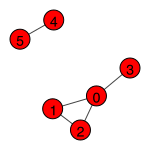

In [6]:
g.add_vertices(2)
g.add_edges([(4, 5)])
igraph.plot(g, bbox=(150, 150), vertex_label=list(range(6)))

What happens if we query the shortest path between nodes in the different component?

In [7]:
g.get_shortest_paths(0, to=5)

/var/folders/j7/9dgqq5g53vnbsbmvh2yqtckr0000gr/T/ipykernel_79546/3289741389.py:1: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  g.get_shortest_paths(0, to=5)


[[]]

You can find the set of nodes in the same connected component by

In [8]:
import numpy as np

np.where(np.array(components.membership) == 0)[0]  # List of nodes with membership = 0
np.where(np.array(components.membership) == 1)[0]  # List of nodes with membership = 1

array([], dtype=int64)

We often care about the largest connected component, which is sometimes referred to as the core of the network. We can make use of numpy unique function in order to obtain the largest connected component.

In [9]:
component_ids, freq = np.unique(
    components.membership, return_counts=True
)
largest_connected_component_id = component_ids[np.argmax(freq)]
nodes_in_largest_component = np.where(
    np.array(components.membership) == largest_connected_component_id
)[
    0
]  # list of nodes in the largest connected component.
print(nodes_in_largest_component)

[0 1 2 3]


Let us break down the code above.
- `np.unique`: returns the unique elements of an array and their counts. With `return_inverse=True`, it also returns the number of times of each unique element appears in the original array, `components.membership`.
- `np.argmax(freq)`: returns the index of the maximum value in the frequency array. Thus, `largest_connected_component_id` is the ID of the largest connected component.
- `components.membership) == largest_connected_component_id` is a boolean array of the same length as `components.membership`, which is True for the nodes in the largest connected component and False otherwise.
- `np.where(...)[0]`: returns the indices of the True values in the boolean array. Thus, `nodes_in_largest_component` is the list of nodes in the largest connected component.

Using the `nodes_in_largest_component`, we can get a subgraph formed by the nodes in the largest connected component.

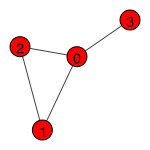

In [10]:
g_sub = g.induced_subgraph(nodes_in_largest_component)
igraph.plot(g_sub, vertex_label=nodes_in_largest_component, bbox=(150, 150))

## Directed networks
Let's extend these ideas about paths and connected components to directed graphs.

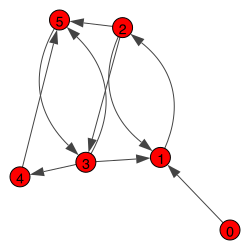

In [11]:
g = igraph.Graph(directed=True)
g.add_vertices(6)
g.add_edges(
    [
        (0, 1),
        (1, 2),
        (2, 1),
        (2, 3),
        (2, 5),
        (3, 1),
        (3, 4),
        (3, 5),
        (4, 5),
        (5, 3),
    ]
)
igraph.plot(g, bbox=(250, 250), vertex_label=list(range(6)))

In a directed graph, we know that an edge from one node to another does not necessarily mean that there is an edge in the opposite direction. This asymmetry also applies to paths in directed graphs. For example, in the given graph, there is a path from node 0 to node 3, but not in the reverse direction.

In [12]:
print("From 0 to 3", g.get_all_simple_paths(0, to=3))
print("From 3 to 0", g.get_all_simple_paths(3, to=0))

From 0 to 3 [[0, 1, 2, 3], [0, 1, 2, 5, 3]]
From 3 to 0 []


The shortest path from 4 to 1 cannot simply go directly to node 3 due to the directionality of the edges; it has to go a longer route.

In [13]:
g.get_shortest_paths(4, 1)

[[4, 5, 3, 1]]

Directed networks have two kinds of connected components.

- **Strongly connected components:** Strongly connected means that there exists a direct path between every pair of nodes, i.e., that from any node to any other nodes while respecting the edge directionality.
- **Weakly connected components:** Weakly connected means that there exists a path between every pair of nodes when ignoring the edge directionality.

In [14]:
print(list(g.connected_components(mode="strong")))
print(list(g.connected_components(mode="weak")))

[[0], [1, 2, 3, 4, 5]]
[[0, 1, 2, 3, 4, 5]]


Now, we are armed with the tools to conduct a small small-world experiment in the next section.